# DEM visualizations

In [ ]:
# dem_path = 'C:\\Users\\ageglio\\OneDrive - DOI\\Documents - Reef Mapping\\Data Release\\NLM_DataRelease\\Updated_DataRelease_Surfaces\\IngallsPoint_New\\0.5m\\IP_BY_0.5m.tif'
# dem_path = "dem\dem.tif"
dem_path = r"C:\Users\ageglio\Documents\NLM_DataRelease\NLM_DataRelease\IngallsPoint_2021\0.5m\IP_BY_0.5m.tif"

## Plot DEM only

In [3]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import resize

def dem_array_plot(dem_path, output_heatmap_path):
    """
    Displays the DEM as a heatmap with a color bar.

    Parameters:
    dem_path (str): Path to the input DEM raster.
    output_heatmap_path (str): Path to save the DEM heatmap.

    Returns:
    None (Saves the heatmap and displays it).
    """
    # Load DEM using Rasterio
    with rasterio.open(dem_path) as dataset:
        dem_array = dataset.read(1)  # Read the first band
  
    # Create a custom colormap with transparency for zero values
    cmap = plt.cm.terrain
    # cmap = plt.cm.terrain_r  # Reverse the colormap
    # cmap = plt.cm.jet
    cmap.set_under(color='none')  # Set color for values below the minimum (zero)

    # Plot DEM heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    heatmap = ax.imshow(dem_array, cmap=cmap, interpolation='none', vmin=150, alpha=0.7)  # DEM background
    plt.colorbar(heatmap, ax=ax, label="Elevation (m)")
    ax.set_title("DEM Heatmap")
    ax.axis("off")  # Hide axes
    # Save the heatmap
    plt.savefig(output_heatmap_path, dpi=600, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory
    del fig, ax, heatmap  # Explicitly delete variables to free up memory
dem_array_plot(dem_path, "____TESTOUT.jpg")

## visualizing Local Binary Patterns

### LBP neighborhood demonstration

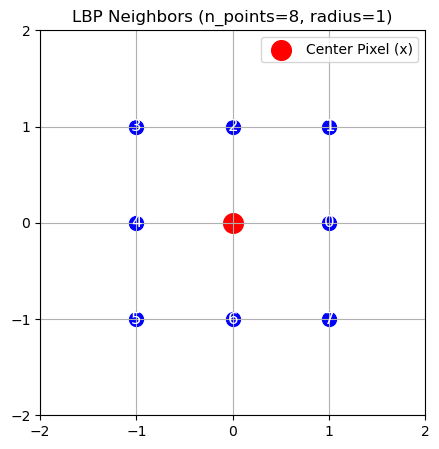

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lbp_neighbors(n_points=8, radius=1):
    """
    Visualizes the LBP neighbor locations around a central pixel.

    Parameters:
    n_points (int): Number of neighboring points.
    radius (int): Distance from the central pixel.
    """
    # Compute neighbor coordinates based on circular pattern
    angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    x_coords = np.round(radius * np.cos(angles)).astype(int)
    y_coords = np.round(radius * np.sin(angles)).astype(int)

    # Plotting setup
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-radius-1, radius+1)
    ax.set_ylim(-radius-1, radius+1)
    ax.set_xticks(range(-radius-1, radius+2))
    ax.set_yticks(range(-radius-1, radius+2))
    ax.grid(True)

    # Plot center pixel
    ax.scatter(0, 0, color='red', s=200, label="Center Pixel (x)")

    # Plot LBP neighbor pixels
    for i in range(n_points):
        ax.scatter(x_coords[i], y_coords[i], color='blue', s=100)
        ax.text(x_coords[i], y_coords[i], str(i), fontsize=12, ha='center', va='center', color="white")

    ax.set_title(f"LBP Neighbors (n_points={n_points}, radius={radius})")
    ax.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Example usage:
plot_lbp_neighbors(n_points=8, radius=1)
# plot_lbp_neighbors(n_points=15, radius=2)
# plot_lbp_neighbors(n_points=21, radius=3)


### LBP

c:\Users\ageglio\AppData\Local\miniforge3\envs\img_processing\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


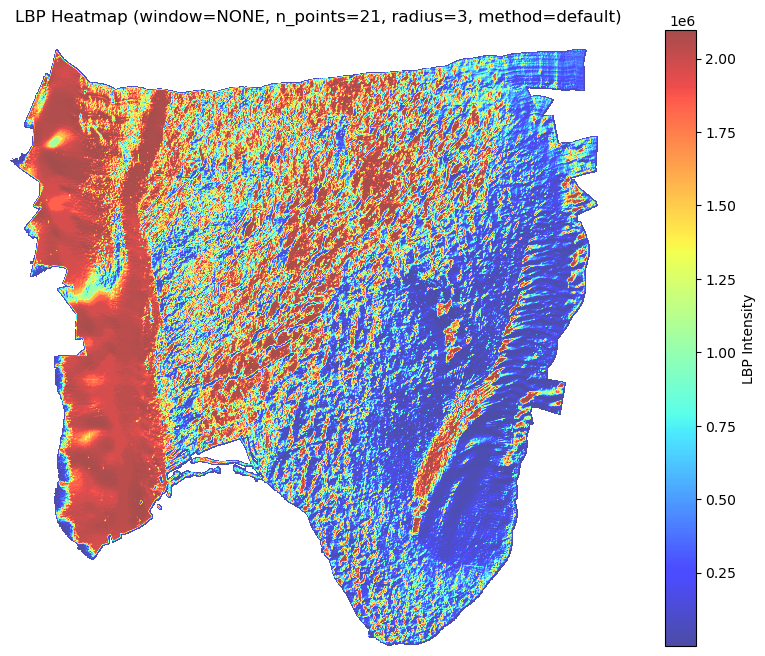

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
# from skimage.feature import local_binary_pattern
from src import *
from matplotlib.colors import ListedColormap

def generate_lbp_heatmap(dem_path, radius, n_points, output_heatmap_path, method='default'):
    """
    Computes the LBP of a DEM and overlays it as a heatmap.

    Parameters:
    dem_path (str): Path to the input DEM raster.
    output_heatmap_path (str): Path to save the LBP heatmap.
    n_points (int): Number of neighboring points for LBP.
    radius (int): Radius for LBP calculation.

    Returns:
    None (Saves the heatmap and displays it).
    """
    # Load DEM using Rasterio
    with rasterio.open(dem_path) as dataset:
        dem_array = dataset.read(1)  # Read the first band
        transform = dataset.transform  # Get geotransform for spatial alignment

    # Compute Local Binary Pattern (LBP)
    lbp_array = HabitatDerivatives().calculate_lbp(dem_array, n_points, radius, method=method)

    # Create a custom colormap with transparency for zero values
    cmap = plt.cm.jet
    cmap.set_under(color='none')  # Set color for values below the minimum (zero)

    # Plot heatmap over DEM
    fig, ax = plt.subplots(figsize=(10, 8))
    # ax.imshow(dem_array, cmap='gray', interpolation='none', alpha=0.6)  # DEM background
    heatmap = ax.imshow(lbp_array, cmap=cmap, alpha=0.7, vmin=0.1)  # LBP overlay with transparency for zero values
    
    plt.colorbar(heatmap, ax=ax, label="LBP Intensity")
    ax.set_title(f"LBP Heatmap (window=NONE, n_points={n_points}, radius={radius}, method={method})")
    ax.axis("off")

    # Save the heatmap
    plt.savefig(output_heatmap_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
n_points = 21
radius = 3
method = 'default'  # or 'uniform', 'nri_uniform', 'ror'
# Generate LBP heatmap
output_heatmap_path = f"lbp_heatmap_{n_points}_{radius}_{method}.png"
generate_lbp_heatmap(dem_path, radius, n_points, output_heatmap_path, method)

## Visualizing flow directions

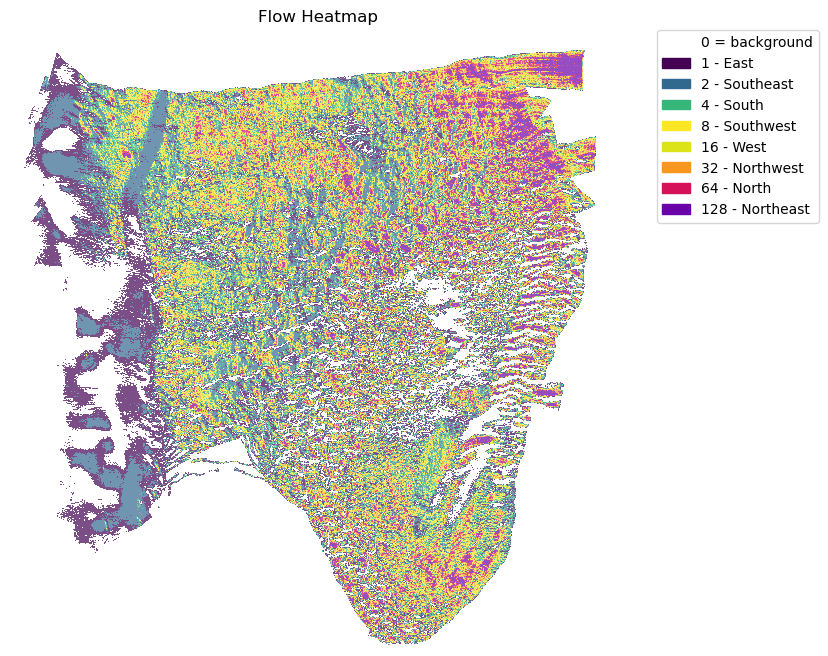

In [2]:
from src import *
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def generate_flow_heatmap(dem_path, output_heatmap_path):
    """
    Computes the flow direction of a DEM and overlays it as a heatmap.

    Parameters:
    dem_path (str): Path to the input DEM raster.
    output_heatmap_path (str): Path to save the LBP heatmap.
    Returns:
    None (Saves the heatmap and displays it).
    """
    # Load DEM using Rasterio
    with rasterio.open(dem_path) as dataset:
        dem_array = dataset.read(1)  # Read the first band
        transform = dataset.transform  # Get geotransform for spatial alignment
    # Compute Local Binary Pattern (LBP)
    flow_array = HabitatDerivatives().calculate_flow_direction(dem_array)

    # Plot heatmap over DEM
    fig, ax = plt.subplots(figsize=(10, 8))
    # Define 8 distinct colors
    custom_cmap = ListedColormap([
        (0, 0, 0, 0),   # Transparent for 0
        "#440154",  # Purple
        "#31688E",  # Blue
        "#35B779",  # Green
        "#FDE725",  # Yellow
        "#DCE319",  # Light Green
        "#F8961E",  # Orange
        "#D41159",  # Red
        "#6A00A8"   # Dark Purple
    ])
    custom_cmap.set_under(color='none')  # Set color for values below the minimum (zero)
    # ax.imshow(dem_array, cmap='terrain', interpolation='none', alpha=0.6)  # DEM background
    ax.imshow(flow_array, cmap=custom_cmap, alpha=0.7)  # overlay
    # Create legend
    legend_labels = [
        "0 = background",
        "1 - East",
        "2 - Southeast",
        "4 - South",
        "8 - Southwest",
        "16 - West",
        "32 - Northwest",
        "64 - North",
        "128 - Northeast",
    ]
    patches = [mpatches.Patch(color=custom_cmap(i), label=legend_labels[i]) for i in range(len(legend_labels))]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_title(f"Flow Heatmap")
    ax.axis("off")

    # Save the heatmap
    plt.savefig(output_heatmap_path, dpi=300, bbox_inches='tight')
    plt.show()
    return flow_array

# Example usage
flow_array = generate_flow_heatmap(dem_path, "flow_heatmap.png")

## Visualize Shannon index

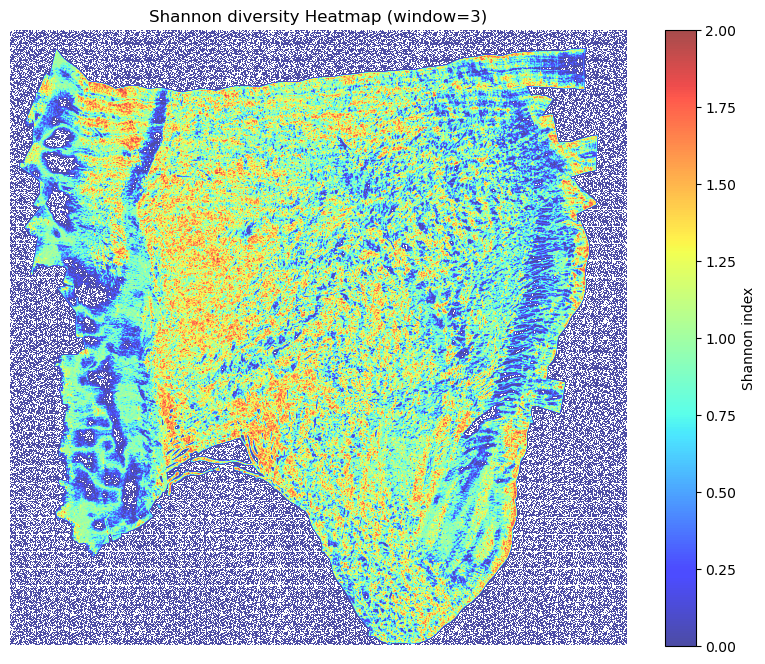

In [6]:
from src import *
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def visualize_flow_direction_and_shannon_index(flow_array, window, output_heatmap_path):
    """
    Computes the shannon diversity index of flow directions overlays it as a heatmap.

    Parameters:
    dem_path (str): Path to the input DEM raster.
    output_heatmap_path (str): Path to save the LBP heatmap.
    window = window size for flow direction calculation
    Returns:
    None (Saves the heatmap and displays it).
    """
    # Compute Shannon Diversity Index
    shannon_array = HabitatDerivatives().calculate_shannon_index_2d(flow_array, window_size=window)
    # Create a custom colormap with transparency for zero values
    cmap = plt.cm.jet
    cmap.set_under(color='none')  # Set color for values below the minimum (zero)

    # Plot heatmap over DEM
    fig, ax = plt.subplots(figsize=(10, 8))
    # ax.imshow(dem_array, cmap='gray', interpolation='none', alpha=0.6)  # DEM background
    heatmap = ax.imshow(shannon_array, cmap=cmap, alpha=0.7, vmin=0, vmax=2)  # LBP overlay with transparency for zero values
    
    plt.colorbar(heatmap, ax=ax, label="Shannon index")
    ax.set_title(f"Shannon diversity Heatmap (window={window})")
    ax.axis("off")

    # Save the heatmap
    plt.savefig(output_heatmap_path, dpi=300, bbox_inches='tight')
    plt.show()

    return shannon_array
window = 3
shannon_array = visualize_flow_direction_and_shannon_index(flow_array, window=window, output_heatmap_path=f"shannon_heatmap_window_{window}.png")

## visualize TPI, TRI, Roughness, Slope, Aspect

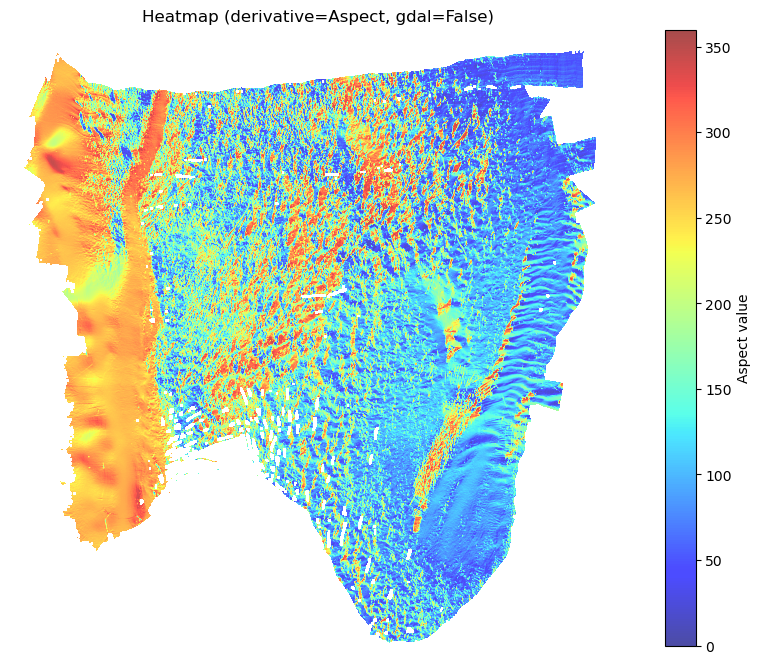

In [2]:
from src import *
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def generate_tpi_tri_roughness_slope_aspect_heatmap(dem_path, variable, use_gdal, output_heatmap_path):
    # Load DEM using Rasterio
    with rasterio.open(dem_path) as dataset:
        dem_array = dataset.read(1)  # Read the first band
    HD = HabitatDerivatives(use_gdal)
    if variable == "TPI":
    # Compute TPI
        derivative = HD.calculate_tpi(dem_array)
    elif variable == "TRI":
    # Compute TRI
        derivative = HD.calculate_tri(dem_array)
    elif variable == "Roughness":
    # Compute Roughness
        derivative = HD.calculate_roughness(dem_array)
    elif variable == "Slope":
    # Compute Slope
        derivative, _ = HD.calculate_slope_aspect(dem_array)
    elif variable == "Aspect":
    # Compute Aspect
        _, derivative = HD.calculate_slope_aspect(dem_array)
    
    # Create a custom colormap with transparency for zero values
    cmap = plt.cm.jet
    # cmap = plt.cm.terrain
    cmap.set_under(color='none')  # Set color for values below the minimum (zero)

    # Plot heatmap over DEM
    fig, ax = plt.subplots(figsize=(10, 8))
    # ax.imshow(dem_array, cmap='gray', interpolation='none', alpha=0.6)  # DEM background
    heatmap = ax.imshow(derivative, cmap=cmap, alpha=0.7) #, vmin=0, vmax=1 # overlay with transparency for zero values
    
    plt.colorbar(heatmap, ax=ax, label=f"{variable} value")
    ax.set_title(f"Heatmap (derivative={variable}, gdal={use_gdal})")
    ax.axis("off")

    # Save the heatmap
    plt.savefig(output_heatmap_path, dpi=300, bbox_inches='tight')
    plt.show()

    return
use_gdal = False
variable = "Aspect"
generate_tpi_tri_roughness_slope_aspect_heatmap(dem_path, variable, use_gdal,
                    output_heatmap_path=f"{variable}_heatmap_use_gdal={use_gdal}.png")
